In [41]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd

import sys
sys.path.append('waveglow/')

from itertools import cycle
import numpy as np
import scipy as sp
from scipy.io.wavfile import write
import pandas as pd
import librosa
import torch

from hparams import create_hparams
from model import Tacotron2, load_model
from waveglow.denoiser import Denoiser
from layers import TacotronSTFT
from data_utils import TextMelLoader, TextMelCollate
from text import cmudict, text_to_sequence
from mellotron_utils import get_data_from_musicxml

In [42]:
def panner(signal, angle):
    angle = np.radians(angle)
    left = np.sqrt(2)/2.0 * (np.cos(angle) - np.sin(angle)) * signal
    right = np.sqrt(2)/2.0 * (np.cos(angle) + np.sin(angle)) * signal
    return np.dstack((left, right))[0]

In [43]:
def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='bottom', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='bottom', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=1)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='bottom', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm")
    plt.tight_layout()

In [44]:
def load_mel(path):
    audio, sampling_rate = librosa.core.load(path, sr=hparams.sampling_rate)
    audio = torch.from_numpy(audio)
    if sampling_rate != hparams.sampling_rate:
        raise ValueError("{} SR doesn't match target {} SR".format(
            sampling_rate, stft.sampling_rate))
    audio_norm = audio / hparams.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = melspec.cuda()
    return melspec

In [45]:
hparams = create_hparams()

In [46]:
stft = TacotronSTFT(hparams.filter_length, hparams.hop_length, hparams.win_length,
                    hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                    hparams.mel_fmax)

## Load Models

In [47]:
checkpoint_path = "models/mellotron_libritts.pt"
checkpoint_path = 'models/mellotron_nof0/checkpoint_25000'
mellotron = load_model(hparams).cuda().eval()
mellotron.load_state_dict(torch.load(checkpoint_path)['state_dict'])

<All keys matched successfully>

In [48]:
waveglow_path = 'models/waveglow_256channels_v4.pt'
waveglow = torch.load(waveglow_path)['model'].cuda().eval()
denoiser = Denoiser(waveglow).cuda().eval()

## Setup dataloaders

In [49]:
arpabet_dict = cmudict.CMUDict('data/cmu_dictionary')
audio_paths = 'data/w24k_example.txt'
dataloader = TextMelLoader(audio_paths, hparams)
datacollate = TextMelCollate(1)

## Load data

In [69]:
file_idx = 3
audio_path, text, sid = dataloader.audiopaths_and_text[file_idx]
print (text)
# text = 'But Barrington seems to think that you managed as well '\
# + 'as you did by getting outside the traces, as he calls it.'
text = 'AITRICS leads the race to optimized precision care,strengthening and trust'
text = 'Our mission is to improve patient outcomes.'
text = 'I think you must be deceived so far.'
# text = 'Nevertheless, I was sorely puzzled.'
# text = 'Did you cross the bridge at that time?'
# text = 'She did not turn her head towards him, although, having such a long and slender neck, she could have done so with very little trouble'

#get audio path, encoded text, pitch contour and mel for gst
text_encoded = torch.LongTensor(text_to_sequence(text, hparams.text_cleaners, arpabet_dict))[None, :].cuda()    
print (text_encoded)
pitch_contour = dataloader[file_idx][3][None].cuda()
mel = load_mel(audio_path)
print(audio_path, text)

print (mel.shape)
pitch_contour = pitch_contour.new_ones(pitch_contour.size())
print (pitch_contour.mean())
# load source data to obtain rhythm using tacotron 2 as a forced aligner
x, y = mellotron.parse_batch(datacollate([dataloader[file_idx]]))


I think you must be deceived so far.
tensor([[123,   8, 171, 146, 157, 153,   8, 182, 178,   8, 155, 111, 168, 170,
           8, 125, 150,   8, 127, 145, 168, 150, 180, 127,   8, 168, 160,   8,
          80,  75,  92,   4]], device='cuda:0')
data-bin/train-clean-100/40/222/40_222_000023_000003.wav I think you must be deceived so far.
torch.Size([1, 80, 221])
tensor(1., device='cuda:0')


In [70]:
speaker_id = torch.LongTensor([0]).cuda()
print (speaker_id)

with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, _ = mellotron.inference(
        (text_encoded, mel, speaker_id, pitch_contour))
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]
#     audio = waveglow.infer(mel_outputs_postnet, sigma=0.8)

ad = (audio[0].data.cpu().numpy())
print (ad.mean())
print (hparams.sampling_rate)
write("audios/{}.wav".format(text), hparams.sampling_rate, ad)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)



tensor([0], device='cuda:0')
-9.16839e-11
24000


In [52]:
ipd.Audio(audio_path, rate=hparams.sampling_rate)
# from shutil import copyfile
# copyfile(audio_path, "audios/reference.wav")


## Define Speakers Set

In [85]:
speaker_ids = TextMelLoader("filelists/libritts_train_clean_100_audiopath_text_sid_atleast5min_val_filelist.txt", hparams).speaker_ids
speakers = pd.read_csv('filelists/libritts_speakerinfo.txt', engine='python',header=None, comment=';', sep=' *\| *', 
                       names=['ID', 'SEX', 'SUBSET', 'MINUTES', 'NAME'])
speakers['MELLOTRON_ID'] = speakers['ID'].apply(lambda x: speaker_ids[x] if x in speaker_ids else -1)
female_speakers = cycle(
    speakers.query("SEX == 'F' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())
male_speakers = cycle(
    speakers.query("SEX == 'M' and MINUTES > 20 and MELLOTRON_ID >= 0")['MELLOTRON_ID'].sample(frac=1).tolist())

In [ ]:
for i, fs in enumerate(female_speakers):
    print (i, fs)
    if i > 10:
        break
#print (speakers['ID'])
# for key in speakers['ID'].keys():
#     if speakers['ID'][key] == 1088:
#         print (key)

# Style Transfer (Rhythm and Pitch Contour)

In [86]:
with torch.no_grad():
    # get rhythm (alignment map) using tacotron 2
    mel_outputs, mel_outputs_postnet, gate_outputs, rhythm = mellotron.forward(x)
    rhythm = rhythm.permute(1, 0, 2)

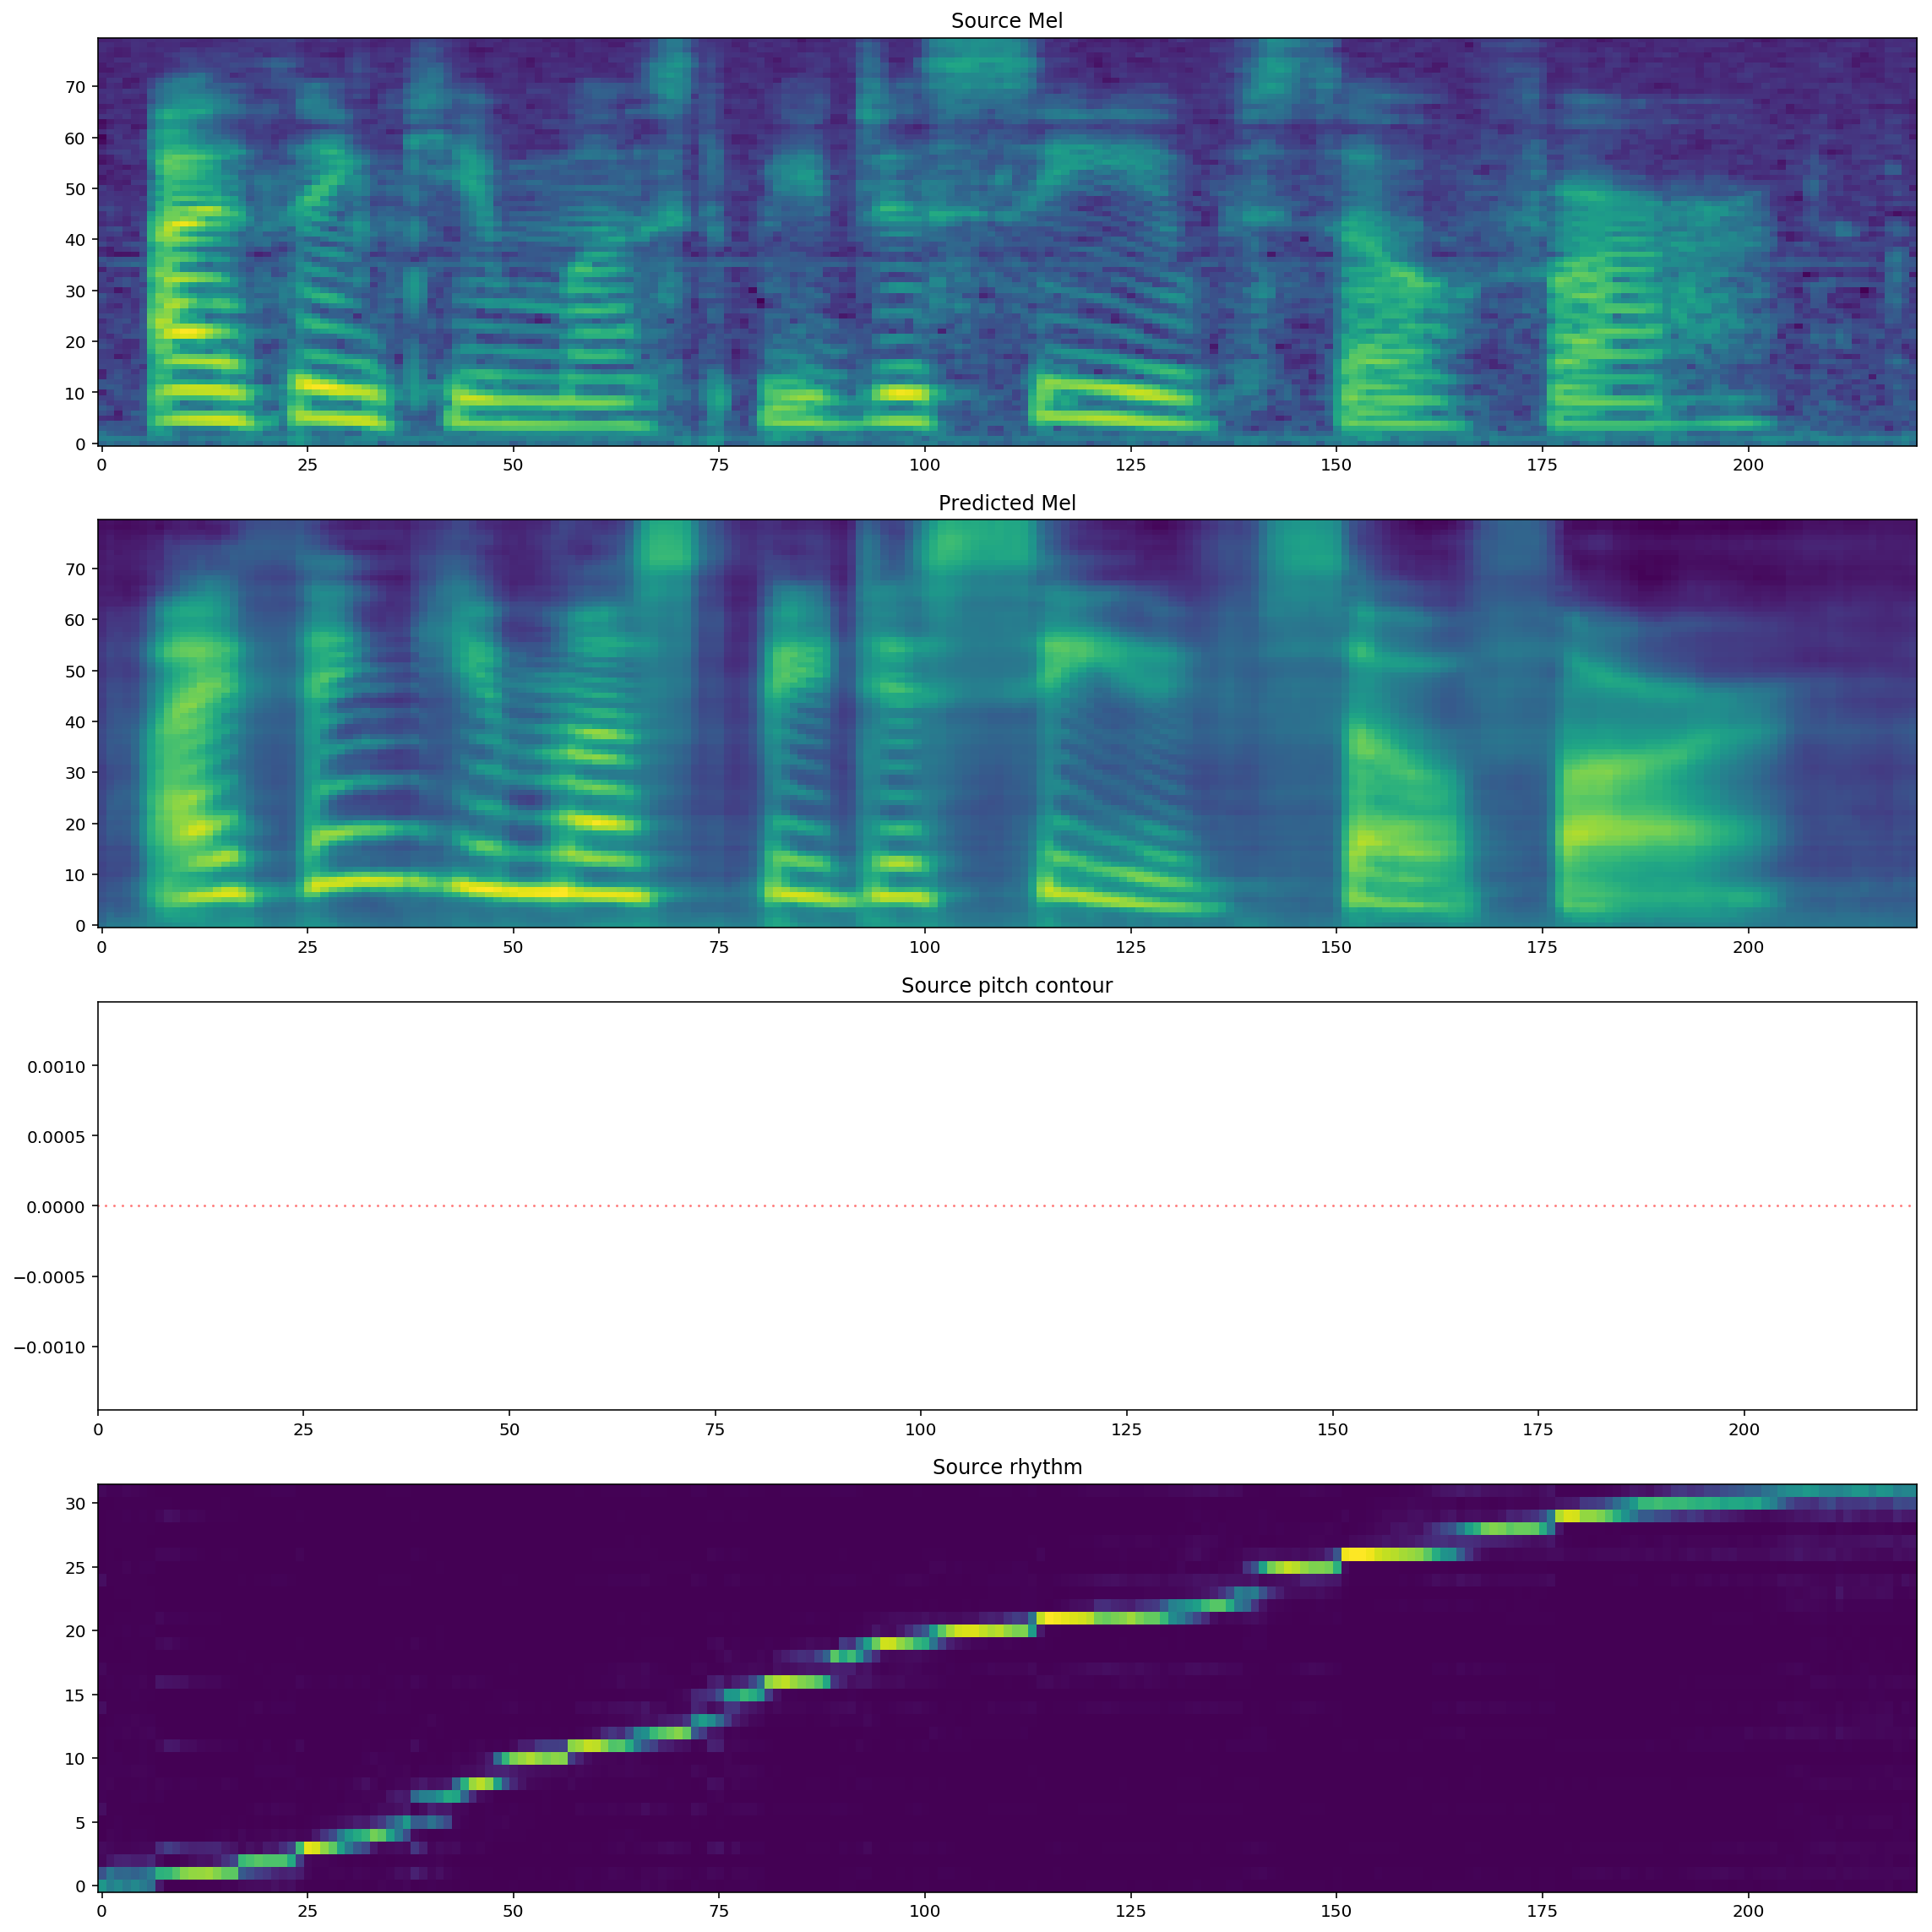

In [87]:
speaker_id = next(female_speakers) if np.random.randint(2) else next(male_speakers)
speaker_id = torch.LongTensor([speaker_id]).cuda()

with torch.no_grad():
    mel_outputs, mel_outputs_postnet, gate_outputs, _ = mellotron.inference_noattention(
        (text_encoded, mel, speaker_id, pitch_contour, rhythm))

plot_mel_f0_alignment(x[2].data.cpu().numpy()[0],
                      mel_outputs_postnet.data.cpu().numpy()[0],
                      pitch_contour.data.cpu().numpy()[0, 0],
                      rhythm.data.cpu().numpy()[:, 0].T)

In [88]:
with torch.no_grad():
    audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[:, 0]
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

# Singing Voice from Music Score

In [ ]:
data = get_data_from_musicxml('data/haendel_hallelujah.musicxml', 132, convert_stress=True)
panning = {'Soprano': [-60, -30], 'Alto': [-40, -10], 'Tenor': [30, 60], 'Bass': [10, 40]}

In [ ]:
n_speakers_per_part = 4
frequency_scaling = 0.4
n_seconds = 90
audio_stereo = np.zeros((hparams.sampling_rate*n_seconds, 2), dtype=np.float32)
for i, (part, v) in enumerate(data.items()):
    rhythm = data[part]['rhythm'].cuda()
    pitch_contour = data[part]['pitch_contour'].cuda()
    text_encoded = data[part]['text_encoded'].cuda()
    
    for k in range(n_speakers_per_part):
        pan = np.random.randint(panning[part][0], panning[part][1])
        if any(x in part.lower() for x in ('soprano', 'alto', 'female')):
            speaker_id = torch.LongTensor([next(female_speakers)]).cuda()
        else:
            speaker_id = torch.LongTensor([next(male_speakers)]).cuda()
        print("{} MellotronID {} pan {}".format(part, speaker_id.item(), pan))

        with torch.no_grad():
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments_transfer = mellotron.inference_noattention(
                (text_encoded, mel, speaker_id, pitch_contour*frequency_scaling, rhythm))

            audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[0, 0]
            audio = audio.cpu().numpy()
            audio = panner(audio, pan)
            audio_stereo[:audio.shape[0]] += audio            
            write("{} {}.wav".format(part, speaker_id.item()), hparams.sampling_rate, audio)

In [ ]:
audio_stereo = audio_stereo / np.max(np.abs(audio_stereo))
write("audio_stereo.wav", hparams.sampling_rate, audio_stereo)
ipd.Audio([audio_stereo[:,0], audio_stereo[:,1]], rate=hparams.sampling_rate)

In [ ]:
# Singing Voice from Music Score

n_speakers_per_part = 4
frequency_scaling = 0.4
n_seconds = 90
audio_stereo = np.zeros((hparams.sampling_rate*n_seconds, 2), dtype=np.float32)
for i, (part, v) in enumerate(data.items()):
    rhythm = data[part]['rhythm'].cuda()
    pitch_contour = data[part]['pitch_contour'].cuda()
    text_encoded = data[part]['text_encoded'].cuda()
    
    for k in range(n_speakers_per_part):
        pan = np.random.randint(panning[part][0], panning[part][1])
        if any(x in part.lower() for x in ('soprano', 'alto', 'female')):
            speaker_id = torch.LongTensor([next(female_speakers)]).cuda()
        else:
            speaker_id = torch.LongTensor([next(male_speakers)]).cuda()
        print("{} MellotronID {} pan {}".format(part, speaker_id.item(), pan))

        with torch.no_grad():
            mel_outputs, mel_outputs_postnet, gate_outputs, alignments_transfer = mellotron.inference_noattention(
                (text_encoded, mel, speaker_id, pitch_contour*frequency_scaling, rhythm))

            audio = denoiser(waveglow.infer(mel_outputs_postnet, sigma=0.8), 0.01)[0, 0]
            audio = audio.cpu().numpy()
            audio = panner(audio, pan)
            audio_stereo[:audio.shape[0]] += audio            
            write("{} {}.wav".format(part, speaker_id.item()), hparams.sampling_rate, audio)